In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shapely
from shapely import geometry
from shapely.geometry import Point
import shapely
import fiona
import glob
from tqdm import tqdm
from shapely.ops import unary_union
import pickle
pd.set_option('display.max_columns', None)

In [2]:
shapely.geos.geos_version

(3, 10, 2)

NDGISHUB_Army_Corps_Lands\Army_Corps_Lands.shp
NDGISHUB_BLM_Surface_and_Mineral_Lands\BLM_Surface_and_Mineral_Lands.shp
NDGISHUB_Military_Reservation\Military_Reservation.shp
NDGISHUB_National_Grasslands\National_Grasslands.shp
NDGISHUB_National_Parks\National_Parks.shp
NDGISHUB_National_Wildlife_Refuges\National_Wildlife_Refuges.shp
NDGISHUB_Reclamation_Lands\Reclamation_Lands.shp
NDGISHUB_Waterfowl_Production_Areas\Waterfowl_Production_Areas.shp


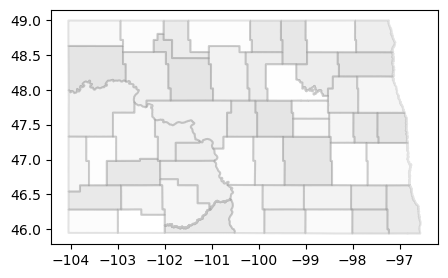

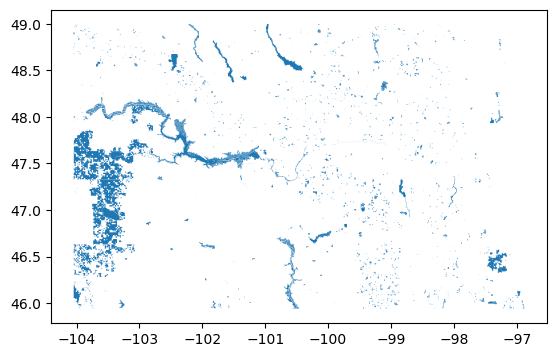

In [3]:
nd_counties = gpd.read_file("NDGISHUB_County_Boundaries\County_Boundaries.shp")

nd_counties.plot(column='NAME',cmap='gist_gray_r', alpha=0.1,edgecolor='k', linewidth=1.5, figsize=(5,5))

fed = glob.glob("NDGISHUB_*/*.shp")
fed.pop(2)

shapes=[]
for x in fed:
    print(x)
    fed_name = (x.split('\\')[1].split('.')[0])
#     print(x.split('\\')[1].split('.')[0])
    gdf = gpd.read_file(x)
    gdf['fed_name']=fed_name
    shapes.append(gdf[['fed_name','geometry']])
#     print(gdf.columns)

federal_lands=pd.concat(shapes)
federal_lands=federal_lands.reset_index(drop=True)


federal_lands.to_file('federal_lands.shp')

federal_lands.plot()

polygons = federal_lands['geometry'].tolist()
boundary = gpd.GeoSeries(unary_union(polygons))
stored = gpd.GeoDataFrame(boundary).rename(columns={0:"geometry"})

In [4]:
geo_df = gpd.read_file("geo_df.shp")
idx = geo_df[geo_df['oil_bbl_da'].isin([np.inf, -np.inf])].index
geo_df = geo_df.drop(idx)
# geo_df[geo_df['oil_bbl_da'].isin([np.inf, -np.inf])].index

fed_map = {0:'Non Federal', 1:'Federal'}
geo_df['on_fed_lan']=geo_df['on_fed_lan'].map(fed_map)

geo_df['oil_per_day']=geo_df['oil']/geo_df['days_in_mo']

In [5]:
well_location=geo_df.drop_duplicates(subset='api_wellno',keep='first').reset_index(drop=True)
well_location.shape

(21030, 35)

In [6]:
on_fed = well_location.loc[well_location['on_fed_lan']=='Federal']

dfs=[]
for idx, x in enumerate(federal_lands['geometry']):
    mask = [y.within(x) for y in on_fed['geometry']]
    df=on_fed[mask]
    if ~df.empty:
        df['fed_land_name'] = federal_lands['fed_name'].iloc[idx]
        dfs.append(df)
well_fed_loc = pd.concat(dfs)

well_dict=dict(zip(well_fed_loc['api_wellno'],well_fed_loc['fed_land_name']))
geo_df['fed_land_name'] = geo_df['api_wellno'].map(well_dict)

geo_df['fed_land_name']=geo_df['fed_land_name'].fillna('Non Federal')

geo_df['fed_land_name'].unique()

C:\Users\matth\anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\matth\anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\matth\anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

C:\Users\matth\anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\matth\anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\matth\anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

array(['Non Federal', 'National_Grasslands', 'Army_Corps_Lands',
       'Waterfowl_Production_Areas', 'BLM_Surface_and_Mineral_Lands',
       'National_Wildlife_Refuges'], dtype=object)

In [8]:
current = (geo_df
           .loc[geo_df['date']=='2022-11-01']
           .query('oil >0')
           .assign(oil_per_day=geo_df['oil']/geo_df['days_in_mo'])
           .drop_duplicates(subset='api_wellno',keep='first')
           .reset_index(drop=True)
          )
current['fed_land_name'] = [x.replace('_',' ') for x in current['fed_land_name']]
current['oil_per_day'].describe()

count    17048.000000
mean        59.328011
std        119.832772
min          0.033333
25%         14.500000
50%         28.333333
75%         55.633333
max       2111.433333
Name: oil_per_day, dtype: float64

In [23]:
geo_df.loc[geo_df['date']=='2022-11-01'].shape

(19597, 36)

In [9]:
current.groupby('company').count().reset_index()[['company','wellname']]

,company,wellname
0,ABRAXAS PETROLEUM CORP,4
1,AEON ENERGY CORP,1
2,ARMSTRONG OPERATING INC,6
3,BALLANTYNE OIL LLC,95
4,BALLARD PETROLEUM HOLDINGS LLC,5
...,...,...
101,WPX ENERGY WILLISTON LLC,612
102,XCL Resources LLC,5
103,XTO ENERGY INC,816
104,ZARGON OIL (ND) INC,52


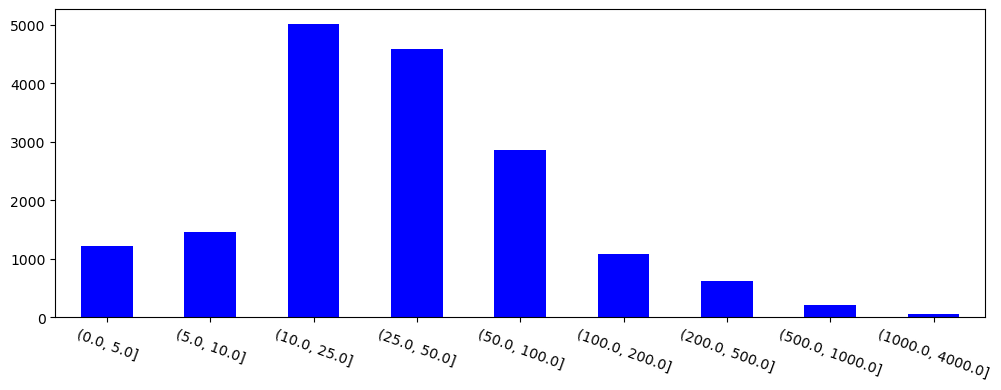

In [10]:
out = pd.qcut(current['oil_bbl_da'], 20)
out = pd.cut(current['oil_per_day'],bins=[0.0,5,10,25,50,100,200,500,1000,4000], include_lowest=False)

ax = out.value_counts(sort=False).plot.bar(rot=-20, color="b", figsize=(12,4))
plt.show()

In [57]:
(geo_df
 .query('oil_per_day>700 and company=="XTO ENERGY INC" and on_fed_lan=="Federal"')
 .drop_duplicates(subset='api_wellno',keep='first')
 .reset_index().shape
)
# current.query('wellname=="SAND CREEK 21-10SH"')

(16, 38)

In [12]:
xx=pd.DataFrame(out.value_counts(sort=False)).reset_index()
xx['index']= xx['index'].astype(str)
xx.rename(columns=({'index':'binned','oil_per_day':'count'}))
xx
# xx.plot.scatter(x='index',y='oil_bbl_da',rot=-20)

,index,oil_per_day
0,"(0.0, 5.0]",1208
1,"(5.0, 10.0]",1449
2,"(10.0, 25.0]",5015
3,"(25.0, 50.0]",4574
4,"(50.0, 100.0]",2852
5,"(100.0, 200.0]",1070
6,"(200.0, 500.0]",620
7,"(500.0, 1000.0]",202
8,"(1000.0, 4000.0]",58


In [13]:
total = current['oil_per_day'].sum()
wells = current['api_wellno'].count()
breakdown = (current
             .loc[current['oil_per_day']>0]
             .groupby('on_fed_lan')
             .agg({'oil_per_day':'sum','api_wellno':'count'})
             .reset_index()[['on_fed_lan', 'api_wellno','oil_per_day']])
breakdown['percent total oil production'] = 100*breakdown['api_wellno']/wells
breakdown['pct'] = 100*breakdown['oil_per_day']/total
breakdown['bbl_per_well'] = breakdown['oil_per_day'] / breakdown['api_wellno']
breakdown = breakdown.round(decimals=2)
breakdown = breakdown.rename(columns={'on_fed_lan':'well location','api_wellno':'total well count',
                          'oil_per_day':'barrels per day','pct':'percent of active wells','bbl_per_well':'barrels per day per well'})
breakdown[['well location', 'total well count', 'percent of active wells',
       'barrels per day','percent total oil production','barrels per day per well']]

,well location,total well count,percent of active wells,barrels per day,percent total oil production,barrels per day per well
0,Federal,569,4.91,49650.73,3.34,87.26
1,Non Federal,16479,95.09,961773.20,96.66,58.36


In [14]:
current.columns

Index(['date', 'reportdate', 'api_wellno', 'fileno', 'company', 'wellname',
       'quarter', 'section', 'township', 'range', 'county', 'fieldname',
       'pool', 'oil', 'wtr', 'days', 'runs', 'gas', 'gas_sold', 'gas_flared',
       'lat', 'long', 'county_nam', 'gas_boe', 'gas_sold_b', 'gas_flar_1',
       'oil_bbl_da', 'gas_boe_da', 'gas_sold_1', 'gas_flar_2', 'year', 'month',
       'days_in_mo', 'on_fed_lan', 'geometry', 'fed_land_name', 'oil_per_day'],
      dtype='object')

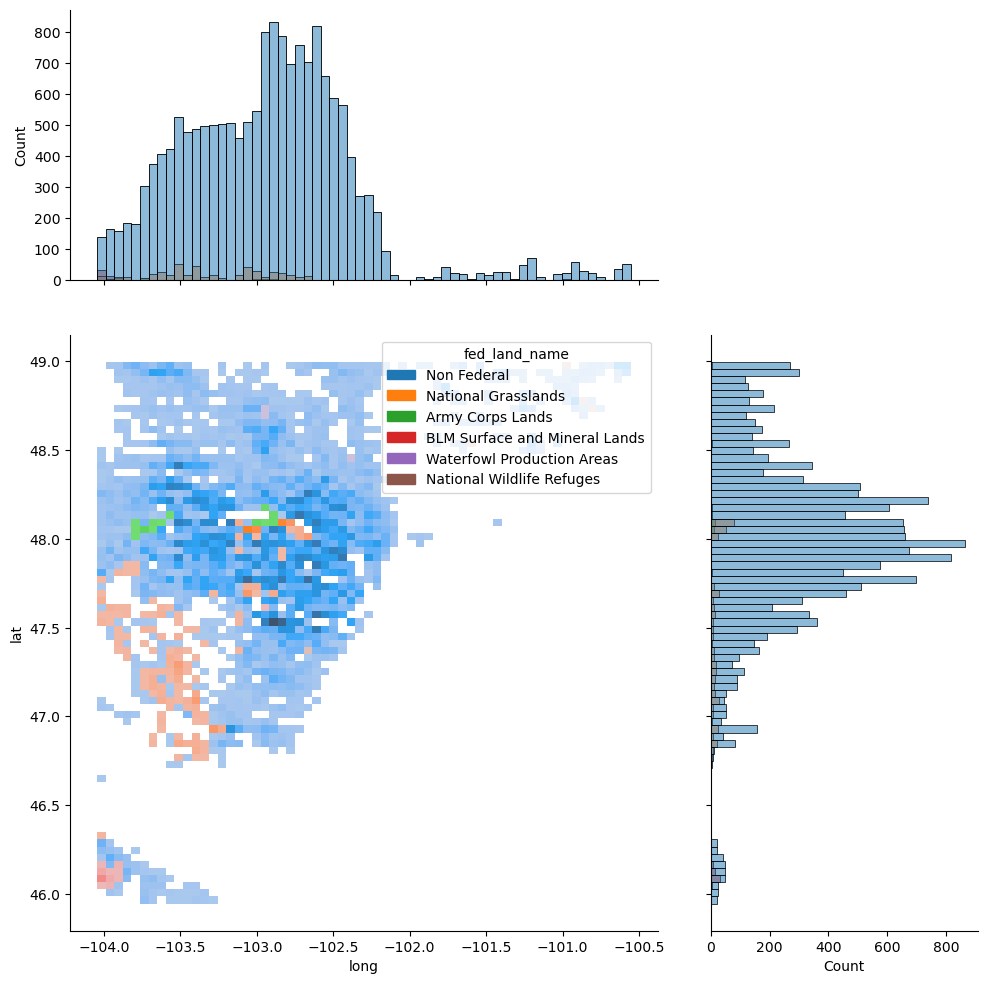

In [58]:
ax=sns.jointplot(data=current, x="long", y="lat", hue="fed_land_name", kind='hist',
                  ratio=2, height=10, marginal_ticks=True, legend=True)


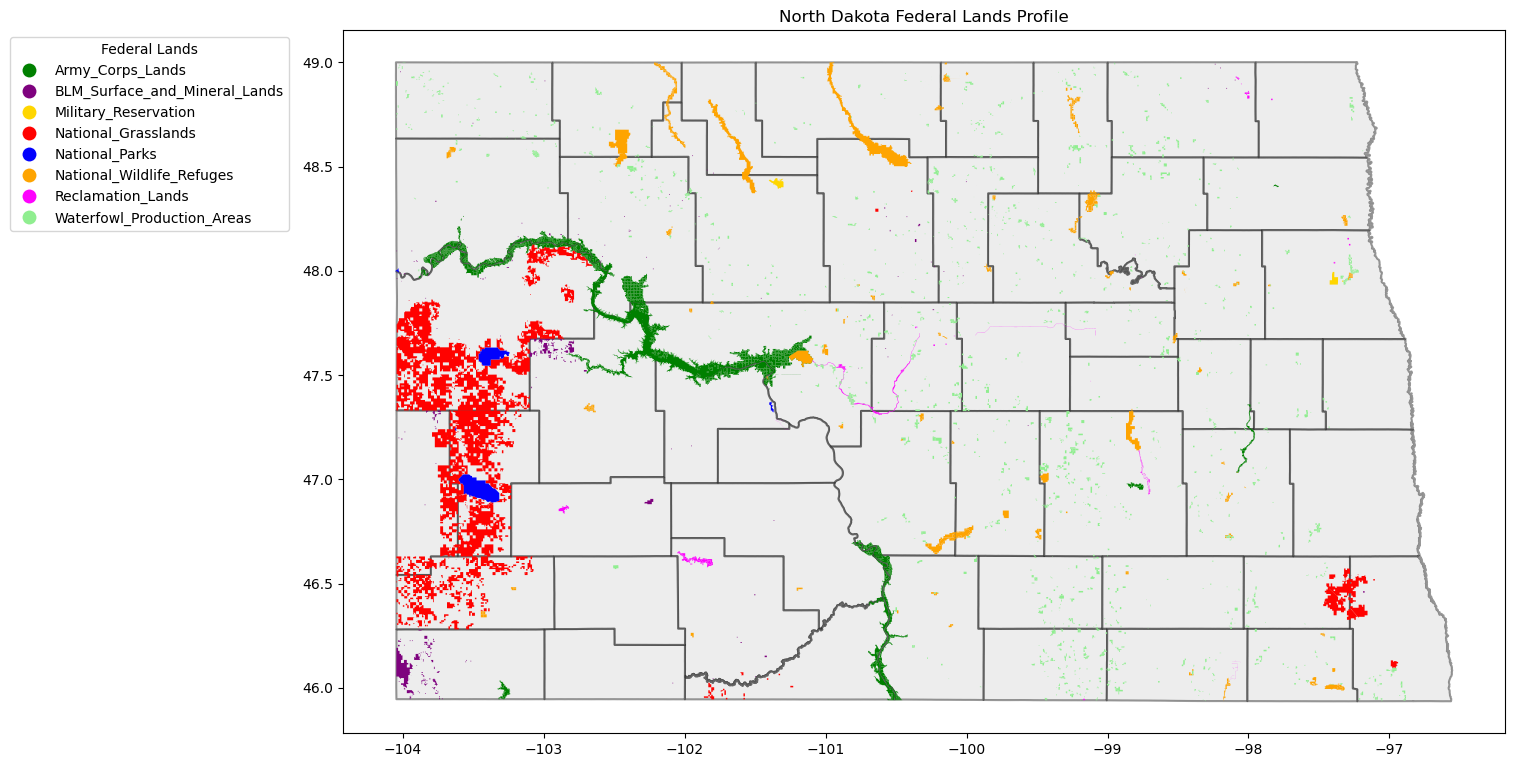

In [24]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","purple","gold","red","blue","orange","magenta",'lightgreen'])
fig, ax = plt.subplots(figsize=(15,11))
nd_counties.plot(ax=ax, color="lightgrey", alpha=0.4,edgecolor='k', linewidth=1.5)
federal_lands.plot(ax=ax, column='fed_name', cmap=cmap, markersize=3, legend=True)
ax.set_title("North Dakota Federal Lands Profile")
leg = ax.get_legend()
leg.set_title("Federal Lands")
leg.set_bbox_to_anchor((-.04, 1, 0, 0))
# plt.xlim(-104.1,-100)
# plt.ylim(47,48.5)
plt.savefig('fed_land_profile.png',bbox_inches='tight',dpi=100)
plt.savefig('1.png',bbox_inches='tight',dpi=100)
plt.show()


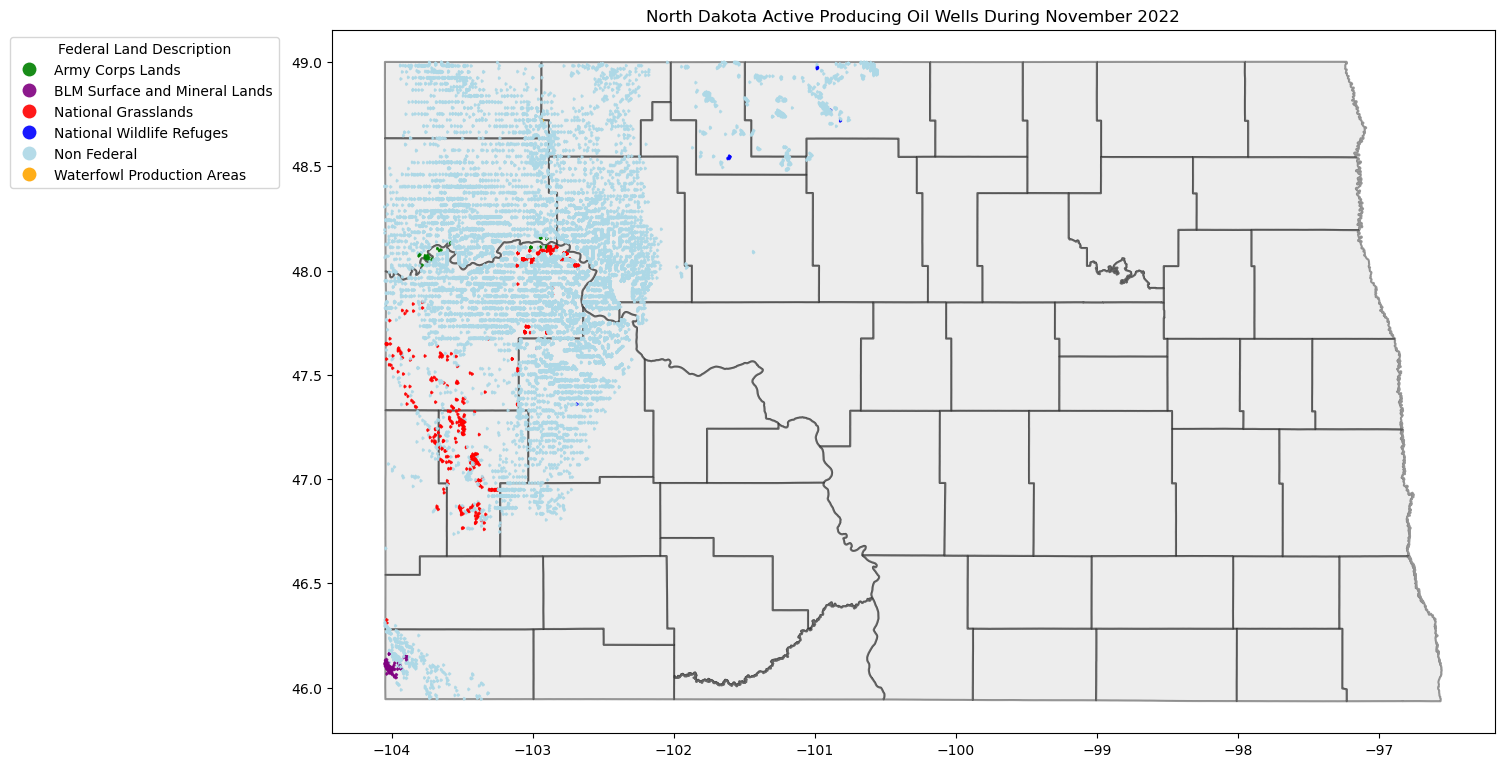

In [52]:
import matplotlib.colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","purple","red","blue","lightblue","orange"])
fig, ax = plt.subplots(figsize=(15,11))
nd_counties.plot(ax=ax, color="lightgrey", alpha=0.4,edgecolor='k', linewidth=1.5)
current.loc[current['oil_per_day']>0].plot(ax=ax, column='fed_land_name', categorical=True,
                                           cmap=cmap, markersize=3, marker=5, alpha=0.9, legend=True)
ax.set_title("North Dakota Active Producing Oil Wells During November 2022")
leg = ax.get_legend()
leg.set_title('Federal Land Description')
leg.set_bbox_to_anchor((-.04, 1, 0, 0))
plt.savefig('fed_or_not.png',bbox_inches='tight',dpi=100)
plt.savefig('2.png',bbox_inches='tight',dpi=100)
plt.show()

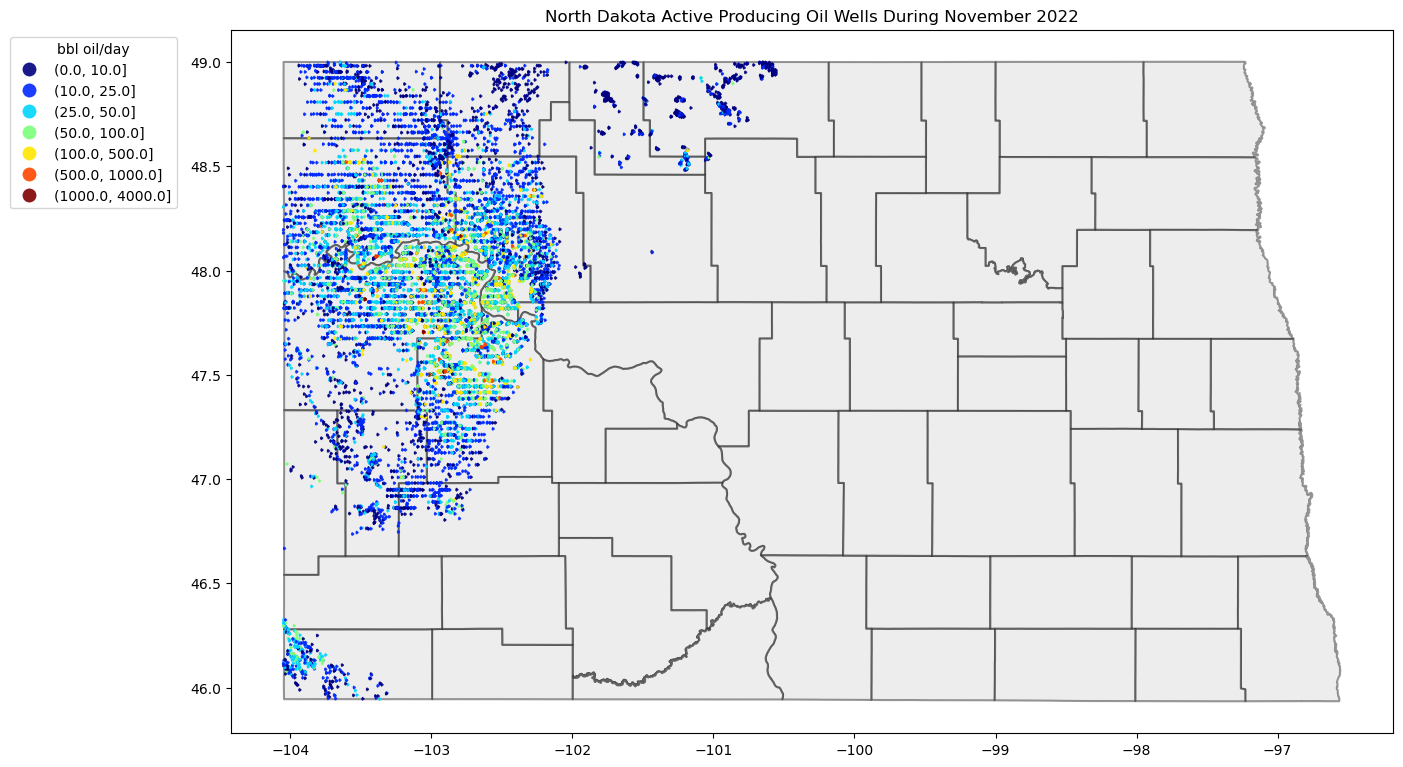

In [26]:
out = pd.cut(current['oil_per_day'],bins=[0.0,10,25,50,100,500,1000,4000], include_lowest=False)
current['oil_binned']=out

import matplotlib.colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","purple","gold","blue","red","orange"])
fig, ax = plt.subplots(figsize=(15,11))
nd_counties.plot(ax=ax, color="lightgrey", alpha=0.4,edgecolor='k', linewidth=1.5)
current.loc[current['oil_per_day']>0].plot(ax=ax, column='oil_binned', categorical=True,
                                           cmap='jet', markersize=3, marker=5, alpha=0.9, legend=True)
# ax[0].set_title("North Dakota and Federal Lands")
ax.set_title("North Dakota Active Producing Oil Wells During November 2022")
leg = ax.get_legend()
leg.set_title('bbl oil/day')
leg.set_bbox_to_anchor((-.04, 1, 0, 0))
# plt.xlim(-104.1,-100)
# plt.ylim(47,48.5)
plt.savefig('oil_wells_binned.png',bbox_inches='tight',dpi=100)
plt.savefig('3.png',bbox_inches='tight',dpi=100)
plt.show()

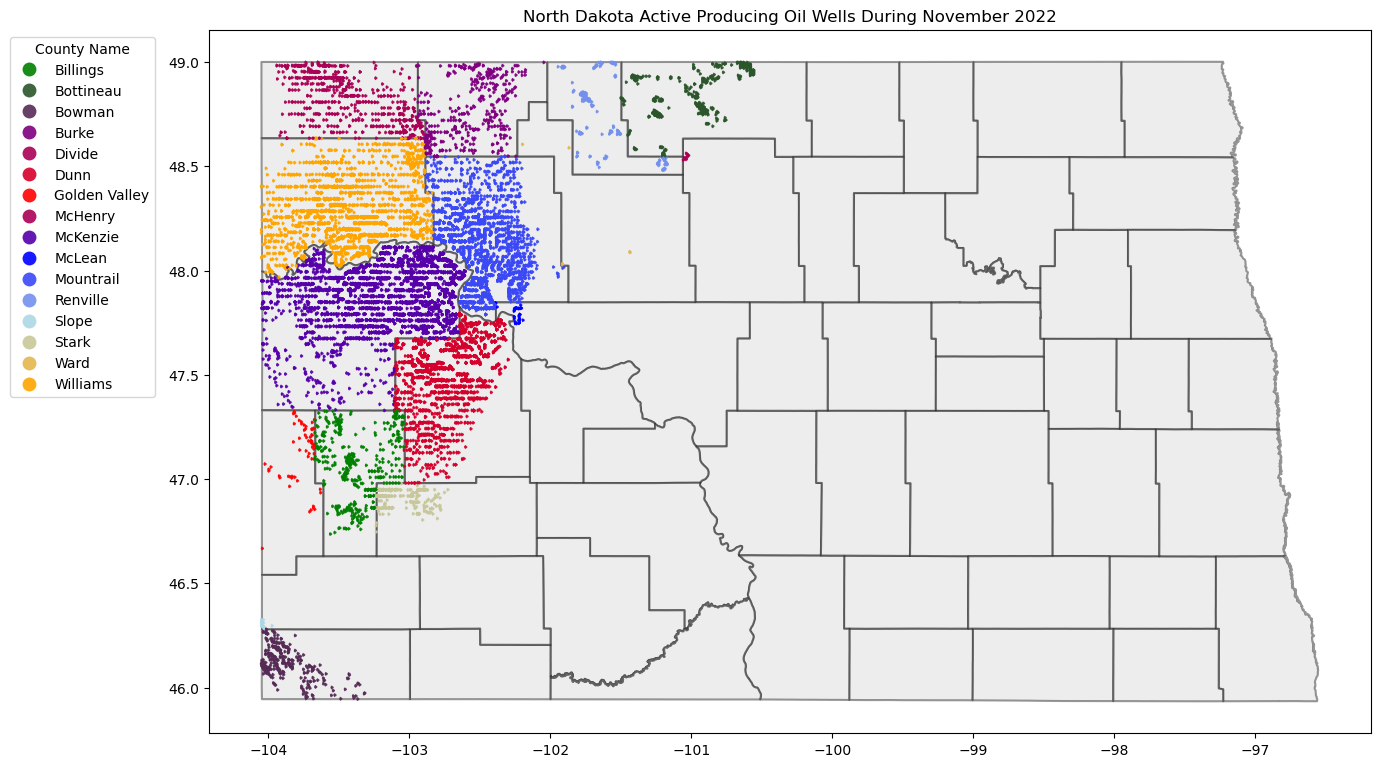

In [27]:
import matplotlib.colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","purple","red","blue","lightblue","orange"])
fig, ax = plt.subplots(figsize=(15,11))
nd_counties.plot(ax=ax, color="lightgrey", alpha=0.4,edgecolor='k', linewidth=1.5)
current.loc[current['oil_per_day']>0].plot(ax=ax, column='county_nam', categorical=True,
                                           cmap=cmap, markersize=3, marker=5, alpha=0.9, legend=True)
# ax[0].set_title("North Dakota and Federal Lands")
ax.set_title("North Dakota Active Producing Oil Wells During November 2022")
leg = ax.get_legend()
leg.set_title('County Name')
leg.set_bbox_to_anchor((-.04, 1, 0, 0))
# plt.xlim(-104.1,-100)
# plt.ylim(47,48.5)
plt.savefig('by_county.png',bbox_inches='tight',dpi=100)
plt.savefig('5.png',bbox_inches='tight',dpi=100)
plt.show()